In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

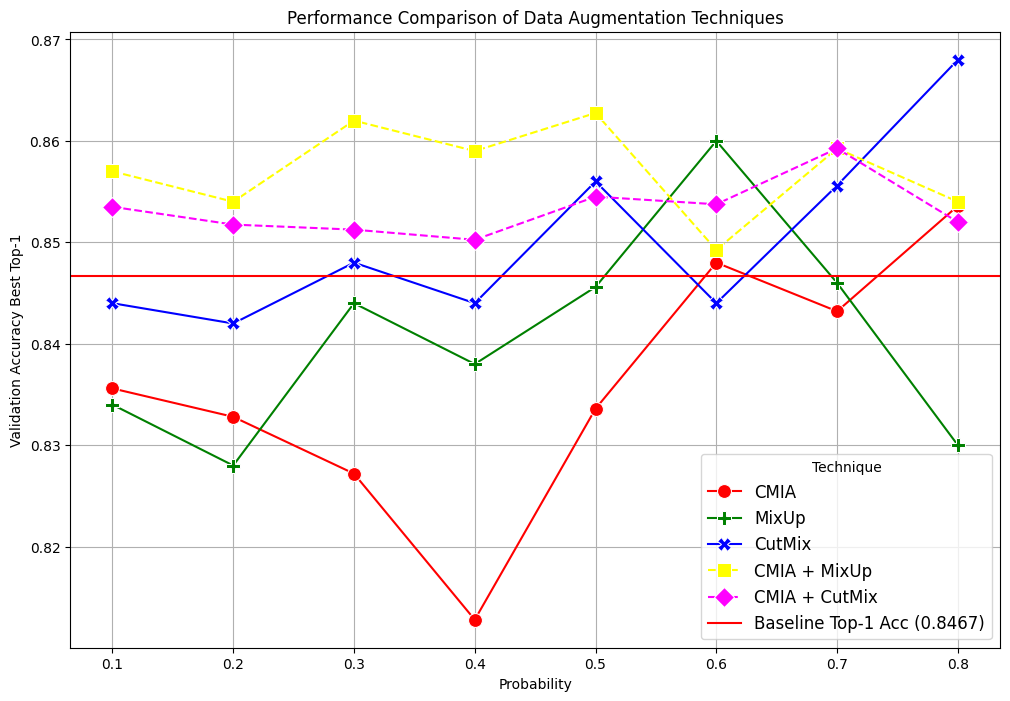

In [16]:
# 데이터 로드
runs_df = pd.read_csv('./project.csv', converters={'summary': ast.literal_eval, 'config': ast.literal_eval})

# 관련 데이터 추출
runs_df['cmia_prob'] = runs_df['config'].apply(lambda x: x.get('data/mixaug_args/cmia_prob', None))
runs_df['mixup_prob'] = runs_df['config'].apply(lambda x: x.get('data/mixup_args/prob', None) if x.get('data/mixup_args/mixup_alpha', 0) == 1 else 0)
runs_df['cutmix_prob'] = runs_df['config'].apply(lambda x: x.get('data/mixup_args/prob', None) if x.get('data/mixup_args/cutmix_alpha', 0) == 1 else 0)
runs_df['val_acc_top1'] = runs_df['summary'].apply(lambda x: x.get('val/acc_top1', None))
runs_df['val_acc_top2'] = runs_df['summary'].apply(lambda x: x.get('val/acc_top2', None))
runs_df['val_acc_best'] = runs_df['summary'].apply(lambda x: x.get('val/acc_best', None))

# 필요한 열에 대해 NaN 값 제거 및 데이터 타입 변환
runs_df.dropna(subset=['cmia_prob', 'mixup_prob', 'cutmix_prob', 'val_acc_top1', 'val_acc_top2'], inplace=True)
runs_df['cmia_prob'] = pd.to_numeric(runs_df['cmia_prob'])
runs_df['mixup_prob'] = pd.to_numeric(runs_df['mixup_prob'])
runs_df['cutmix_prob'] = pd.to_numeric(runs_df['cutmix_prob'])
runs_df['val_acc_top1'] = pd.to_numeric(runs_df['val_acc_top1'])
runs_df['val_acc_top2'] = pd.to_numeric(runs_df['val_acc_top2'])
runs_df['val_acc_best'] = pd.to_numeric(runs_df['val_acc_best'])

# 기준 성능(베이스라인) 추출
baseline_top1_acc = runs_df[(runs_df['cmia_prob'] == 0) & (runs_df['mixup_prob'] == 0) & (runs_df['cutmix_prob'] == 0)]['val_acc_best'].mean()

# CMIA에 대해 MixUp과 CutMix가 적용되지 않은 경우만 고려 (mixup_prob과 cutmix_prob이 모두 0인 경우)
cmia_data = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] == 0) & (runs_df['cutmix_prob'] == 0)]

# MixUp과 CutMix에 대해 CMIA가 적용되지 않은 경우만 고려 (cmia_prob이 0인 경우)
mixup_data = runs_df[(runs_df['mixup_prob'] > 0) & (runs_df['cmia_prob'] == 0)]
cutmix_data = runs_df[(runs_df['cutmix_prob'] > 0) & (runs_df['cmia_prob'] == 0)]

cmia_mixup_data = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] > 0) & (runs_df['cutmix_prob'] == 0)]
cmia_cutmix_data = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] == 0) & (runs_df['cutmix_prob'] > 0)]

# 각 기법별 평균 정확도 계산
cmia_means = cmia_data.groupby('cmia_prob')['val_acc_best'].mean().reset_index()
mixup_means = mixup_data.groupby('mixup_prob')['val_acc_best'].mean().reset_index()
cutmix_means = cutmix_data.groupby('cutmix_prob')['val_acc_best'].mean().reset_index()

cmia_mixup_means = cmia_mixup_data.groupby(['cmia_prob'])['val_acc_best'].mean().reset_index()
cmia_cutmix_means = cmia_cutmix_data.groupby(['cmia_prob'])['val_acc_best'].mean().reset_index()

# 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cmia_means, x='cmia_prob', y='val_acc_best', label='CMIA', marker='o', markersize=10, color='red')
sns.lineplot(data=mixup_means, x='mixup_prob', y='val_acc_best', label='MixUp', marker='P', markersize=10, color='green')
sns.lineplot(data=cutmix_means, x='cutmix_prob', y='val_acc_best', label='CutMix', marker='X', markersize=10, color='blue')
sns.lineplot(data=cmia_mixup_means, x='cmia_prob', y='val_acc_best', label='CMIA + MixUp', marker='s', markersize=10, color='yellow', linestyle='dashed')
sns.lineplot(data=cmia_cutmix_means, x='cmia_prob', y='val_acc_best', label='CMIA + CutMix', marker='D', markersize=10, color='magenta', linestyle='dashed')

# 베이스라인 성능 추가
plt.axhline(y=baseline_top1_acc, color='red', linestyle='-', label=f'Baseline Top-1 Acc ({baseline_top1_acc:.4f})')
plt.xlabel('Probability')
plt.ylabel('Validation Accuracy Best Top-1')
plt.title('Performance Comparison of Data Augmentation Techniques')
plt.legend(title='Technique', loc='lower right', fontsize='large')
plt.grid(True)
plt.show()


In [8]:
# Baseline, CutMix, MixUp, 그리고 CMIA 적용된 경우에 대한 성능 비교

# Baseline 성능
baseline_performance = baseline_top1_acc

# CutMix, MixUp 별도 적용 시의 성능
cutmix_performance = runs_df[(runs_df['cmia_prob'] == 0) & (runs_df['cutmix_prob'] > 0)].groupby('cutmix_prob')['val_acc_best'].mean()
mixup_performance = runs_df[(runs_df['cmia_prob'] == 0) & (runs_df['mixup_prob'] > 0)].groupby('mixup_prob')['val_acc_best'].mean()
cmia_performance = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] == 0) & (runs_df['cutmix_prob'] == 0)].groupby('cmia_prob')['val_acc_best'].mean()

# CMIA + CutMix, CMIA + MixUp 조합 적용 시의 성능
cmia_cutmix_performance = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['cutmix_prob'] > 0)].groupby('cutmix_prob')['val_acc_best'].mean()
cmia_mixup_performance = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] > 0)].groupby('mixup_prob')['val_acc_best'].mean()

# 성능 비교를 위한 표 생성
performance_comparison_df = pd.DataFrame({
    'Probability': cutmix_performance.index,
    'Baseline': baseline_performance,
    'CMIA Only' : cmia_performance.reindex(cutmix_performance.index, fill_value=baseline_performance),
    'CutMix Only': cutmix_performance,
    'MixUp Only': mixup_performance.reindex(cutmix_performance.index, fill_value=baseline_performance),
    'CMIA + CutMix': cmia_cutmix_performance.reindex(cutmix_performance.index, fill_value=baseline_performance),
    'CMIA + MixUp': cmia_mixup_performance.reindex(cutmix_performance.index, fill_value=baseline_performance)
}).fillna(baseline_performance).reset_index(drop=True)

performance_comparison_df

,Probability,Baseline,CMIA Only,CutMix Only,MixUp Only,CMIA + CutMix,CMIA + MixUp
0,0.1,0.846667,0.8356,0.8440,0.8340,0.83975,0.84475
1,0.2,0.846667,0.8328,0.8420,0.8280,0.85375,0.85775
2,0.3,0.846667,0.8272,0.8480,0.8440,0.84800,0.85250
3,0.4,0.846667,0.8128,0.8440,0.8380,0.85925,0.86050
4,0.5,0.846667,0.8336,0.8560,0.8456,0.85425,0.86200
5,0.6,0.846667,0.8480,0.8440,0.8600,0.85700,0.85550
6,0.7,0.846667,0.8432,0.8556,0.8460,0.85975,0.85775
7,0.8,0.846667,0.8536,0.8680,0.8300,0.85450,0.86650


In [9]:
cmia_performance.mean()

0.8358499974012374

In [6]:
# CutMix Only 및 MixUp Only의 전체 평균 성능 계산
average_cutmix_only_performance = cutmix_performance.mean()
average_mixup_only_performance = mixup_performance.mean()

# CMIA 적용 시 CutMix 및 MixUp의 각 확률별 성능
cmia_cutmix_performance_by_cmia_prob = runs_df[runs_df['cutmix_prob'] > 0].groupby('cmia_prob')['val_acc_top1'].mean()
cmia_mixup_performance_by_cmia_prob = runs_df[runs_df['mixup_prob'] > 0].groupby('cmia_prob')['val_acc_top1'].mean()

# 결과 표시
performance_comparison_by_cmia_prob_df = pd.DataFrame({
    'CMIA Probability': cmia_cutmix_performance_by_cmia_prob.index,
    'CutMix Only': average_cutmix_only_performance,
    'CMIA + CutMix': cmia_cutmix_performance_by_cmia_prob.values,
    'MixUp Only': average_mixup_only_performance,
    'CMIA + MixUp': cmia_mixup_performance_by_cmia_prob.values
}).reset_index(drop=True)

performance_comparison_by_cmia_prob_df



,CMIA Probability,CutMix Only,CMIA + CutMix,MixUp Only,CMIA + MixUp
0,0.0,0.83445,0.836833,0.82815,0.83050
1,0.1,0.83445,0.838750,0.82815,0.83825
2,0.2,0.83445,0.839500,0.82815,0.84100
3,0.3,0.83445,0.838500,0.82815,0.85025
4,0.4,0.83445,0.839500,0.82815,0.84325
5,0.5,0.83445,0.841500,0.82815,0.85100
6,0.6,0.83445,0.840250,0.82815,0.83850
7,0.7,0.83445,0.844500,0.82815,0.84725
8,0.8,0.83445,0.844250,0.82815,0.84450


In [5]:
# Baseline, CutMix, MixUp, 그리고 CMIA 적용된 경우에 대한 성능 비교

# Baseline 성능
baseline_performance = baseline_top1_acc

# CutMix, MixUp 별도 적용 시의 성능
cutmix_performance = runs_df[(runs_df['cmia_prob'] == 0) & (runs_df['cutmix_prob'] > 0)].groupby('cutmix_prob')['val_acc_top1'].mean()
mixup_performance = runs_df[(runs_df['cmia_prob'] == 0) & (runs_df['mixup_prob'] > 0)].groupby('mixup_prob')['val_acc_top1'].mean()
mixup_performance = runs_df[(runs_df['cmia_prob'] == 0) & (runs_df['mixup_prob'] > 0)].groupby('mixup_prob')['val_acc_top1'].mean()
cmia_performance = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] == 0) & (runs_df['cutmix_prob'] == 0)].groupby('cmia_prob')['val_acc_top1'].mean()

# CMIA + CutMix, CMIA + MixUp 조합 적용 시의 성능
cmia_cutmix_performance = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['cutmix_prob'] > 0)].groupby('cutmix_prob')['val_acc_top1'].mean()
cmia_mixup_performance = runs_df[(runs_df['cmia_prob'] > 0) & (runs_df['mixup_prob'] > 0)].groupby('mixup_prob')['val_acc_top1'].mean()

# 성능 비교를 위한 표 생성
performance_comparison_df = pd.DataFrame({
    'Probability': cutmix_performance.index,
    'Baseline': baseline_performance,
    'CutMix Only': cutmix_performance,
    'CMIA Only': cmia_performance,
    'MixUp Only': mixup_performance.reindex(cutmix_performance.index, fill_value=baseline_performance),
    'CMIA + CutMix': cmia_cutmix_performance.reindex(cutmix_performance.index, fill_value=baseline_performance),
    'CMIA + MixUp': cmia_mixup_performance.reindex(cutmix_performance.index, fill_value=baseline_performance)
}).fillna(baseline_performance).reset_index(drop=True)

performance_comparison_df

,Probability,Baseline,CutMix Only,CMIA Only,MixUp Only,CMIA + CutMix,CMIA + MixUp
0,0.1,0.832,0.8320,0.8252,0.8140,0.82550,0.83175
1,0.2,0.832,0.8200,0.7928,0.8140,0.84050,0.84700
2,0.3,0.832,0.8400,0.7976,0.8280,0.84075,0.83825
3,0.4,0.832,0.8320,0.7652,0.8380,0.84725,0.84850
4,0.5,0.832,0.8320,0.8220,0.8352,0.84375,0.84750
5,0.6,0.832,0.8320,0.8200,0.8420,0.84250,0.84575
6,0.7,0.832,0.8416,0.8348,0.8340,0.84450,0.84475
7,0.8,0.832,0.8460,0.8400,0.8200,0.84200,0.85050


In [7]:
cmia_performance.mean()

0.8122000023722649

In [10]:
# 제공된 데이터를 기반으로 Overall 성능 및 CMIA 추가에 따른 성능 향상 계산

# MixUp Only 및 CMIA 추가 시의 성능 데이터를 백분율 형태로 변환
mixup_only_values = [x * 100 for x in [0.8140, 0.8140, 0.8280, 0.8380, 0.8352, 0.8420, 0.8340, 0.8200]]
cmia_mixup_values = [x * 100 for x in [0.8318, 0.8470, 0.8383, 0.8485, 0.8475, 0.8458, 0.8448, 0.8505]]

# CutMix Only 및 CMIA 추가 시의 성능 데이터를 백분율 형태로 변환
cutmix_only_values = [x * 100 for x in [0.832, 0.8200, 0.8400, 0.8320, 0.8320, 0.8320, 0.8416, 0.8460]]
cmia_cutmix_values = [x * 100 for x in [0.8255, 0.8405, 0.8408, 0.8473, 0.8438, 0.8425, 0.8445, 0.8420]]


# Overall 성능 및 성능 향상 계산
overall_mixup = sum(mixup_only_values) / len(mixup_only_values)
overall_cmia_mixup = sum(cmia_mixup_values) / len(cmia_mixup_values)
performance_change_mixup = [b - a for a, b in zip(mixup_only_values, cmia_mixup_values)]

overall_cutmix = sum(cutmix_only_values) / len(cutmix_only_values)
overall_cmia_cutmix = sum(cmia_cutmix_values) / len(cmia_cutmix_values)
performance_change_cutmix = [b - a for a, b in zip(cutmix_only_values, cmia_cutmix_values)]

# 결과 출력

print(f'Overall MixUp Performance: {overall_mixup:.4f}')
print(f'Overall CMIA + MixUp Performance: {overall_cmia_mixup:.4f}')
print(f'Performance Change_mixup: {performance_change_mixup}')

print(f'Overall CutMix Performance: {overall_cutmix:.4f}')
print(f'Overall CMIA + CutMix Performance: {overall_cmia_cutmix:.4f}')
print(f'Performance Change_cutmix: {performance_change_cutmix}')



Overall MixUp Performance: 82.8150
Overall CMIA + MixUp Performance: 84.4275
Performance Change_mixup: [1.7800000000000011, 3.3000000000000114, 1.0300000000000011, 1.0500000000000114, 1.2299999999999898, 0.37999999999999545, 1.0800000000000125, 3.049999999999997]
Overall CutMix Performance: 83.4450
Overall CMIA + CutMix Performance: 84.0863
Performance Change_cutmix: [-0.6500000000000057, 2.049999999999997, 0.0799999999999983, 1.5300000000000011, 1.1799999999999926, 1.0499999999999972, 0.29000000000000625, -0.3999999999999915]
